# Анализ А/В-теста крупного интернет-магазина

Я — аналитик крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Нужно приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

**План работы**: 

    1. Проверить достаточно ли данных для анализа и A/B-теста
    2. Предобработка данных
    3. Приоритизация гипотез
    4. Построить графики кумулятивных метрик
    5. Построить точечные графики метрик
    6. Определить аномалии
    7. Рассчитать стат.значимости различий метрик по "сырым" и "очищенным" данным
    8. Принять решение по результатам теста 
    9. Вывод

## ОБЩАЯ ИНФОРМАЦИЯ

In [1]:
#библиотеки
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()
import warnings

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
#функция для вывода информации о таблице и дублях
def analyze_dataframe(df):
    # Выводим первые 5 строк датафрейма
    print('\033[1m' + 'head:' + '\033[0m')
    print(df.head())
    
    # Выводим информацию о датафрейме
    print('\033[1m' + 'info:' + '\033[0m')
    print(df.info())
    
    # Выводим форму датафрейма
    print('\033[1m' + 'shape:' + '\033[0m')
    print(df.shape)
    
    # Вычисляем и выводим количество дублирующихся строк
    duplicate_count = df.duplicated().sum()
    print('\033[1m' + 'Количество дубликатов в таблице:' + '\033[0m')
    print(duplicate_count)

In [4]:
analyze_dataframe(hypothesis)

head:
                                          Hypothesis  Reach  Impact  \
0  Добавить два новых канала привлечения трафика,...      3      10   
1  Запустить собственную службу доставки, что сок...      2       5   
2  Добавить блоки рекомендаций товаров на сайт ин...      8       3   
3  Изменить структура категорий, что увеличит кон...      8       3   
4  Изменить цвет фона главной страницы, чтобы уве...      3       1   

   Confidence  Efforts  
0           8        6  
1           4       10  
2           7        3  
3           3        8  
4           1        1  
info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
mem

In [5]:
#увеличим количество символов для выведения текста гипотезы
pd.options.display.max_colwidth = 120
display(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Видим, что гипотез 9. Наименования столбцов некорректные.

In [6]:
analyze_dataframe(orders)

head:
   transactionId   visitorId        date  revenue group
0     3667963787  3312258926  2019-08-15     1650     B
1     2804400009  3642806036  2019-08-15      730     B
2     2961555356  4069496402  2019-08-15      400     A
3     3797467345  1196621759  2019-08-15     9759     B
4     2282983706  2322279887  2019-08-15     2308     B
info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
shape:
(1197, 5)
Количество дубликатов в таблице:
0


In [7]:
#посмотрим за какой период представлены данные
display(orders['date'].min())
orders['date'].max()

'2019-08-01'

'2019-08-31'

Видим 1197 строк данных о заказах за период с 1 по 31 августа 2019. Некорректный тип данных у даты и некорректные наименования столбцов.

In [8]:
analyze_dataframe(visitors)

head:
         date group  visitors
0  2019-08-01     A       719
1  2019-08-02     A       619
2  2019-08-03     A       507
3  2019-08-04     A       717
4  2019-08-05     A       756
info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
shape:
(62, 3)
Количество дубликатов в таблице:
0


In [9]:
#посмотрим за какой период представлены данные
display(visitors['date'].min())
visitors['date'].max()

'2019-08-01'

'2019-08-31'

Видим 62 строки данных о количестве пользователей по группам за период с 1 по 31 августа 2019. Некорректный тип данных у даты.

### Промежуточный вывод: 

В нашем распоряжении 1197 строк данных о заказах, 62 строки данных о количестве пользователей по группам за период с 1 по 31 августа 2019 и 9 гипотез. 
Этих данных достаточно для анализа и A/B-теста. 
Видим что имеются некорректные типы данных и некорректные наименования столбцов. Пропуски и дубликаты отсутствуют.

## ПРЕДОБРАБОТКА ДАННЫХ

### Преобразование типов данных

In [10]:
# преобразуем данные о датах
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [11]:
#проверим
display(orders.info())
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Изменили тип данных в данных по дате

### Переименование столбцов

In [12]:
#уберем заглавные буквы
hypothesis.columns = hypothesis.columns.str.lower()

In [13]:
#проверим
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [14]:
#скорректируем наименования
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId':'visitor_id'})

In [15]:
#проверим
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Наименования столбцов скорректированы.

### Промежуточный вывод

Проведена предобработка:
1. изменены типы данных:
 - date — дата
2. скорректированы наименования столбцов 
 - hypothesis — краткое описание гипотезы
 - reach — охват пользователей по 10-балльной шкале
 - impact — влияние на пользователей по 10-балльной шкале
 - confidence — уверенность в гипотезе по 10-балльной шкале
 - efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале
 - transaction_id — идентификатор заказа
 - visitor_id — идентификатор пользователя, совершившего заказ
 

## Приоритизация гипотез

### ICE

Применим фреймворк ICE для приоритизации гипотез

In [16]:
#создадим новый столбец для расчета ICE
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

In [17]:
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее перспективными гипотезы по ICE являются:
- (8) Запустить акцию, дающую скидку на товар в день рождения
- (0) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- (7) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- (6) Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	
- (2) Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

### RICE

Применим фреймворк RICE для приоритизации гипотез

In [18]:
#создадим новый столбец для расчета RICE
hypothesis['RICE']=hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

In [19]:
hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Наиболее перспективными гипотезы по RICE являются:
- (7) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- (2) Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- (0) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- (6) Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
- (8) Запустить акцию, дающую скидку на товар в день рождения

Сами гипотезы такие же как по ICE, но их приоритетность изменилась. 
Связано это с тем, что мы при расчете по RICE мы учитываем скольких пользователей эти изменения затронут. И гипотезы с большим охватом пользователей более приоритетны по RICE.

### Промежуточный вывод

Самыми приоритетными гипотезами являются:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
- Запустить акцию, дающую скидку на товар в день рождения

## Анализ A/B-теста

### Графики кумулятивных метрик

#### График кумулятивной выручки по группам

Построим график кумулятивной выручки по группам

In [20]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [21]:
#добавим в него кумулятивные данные о кол-ве заказов, пользователей и сумме выручке по группам
ordersAggregated = datesGroups.apply(
    lambda x:orders[np.logical_and(orders['date']<= x['date'], orders['group'] == x['group'])
                   ].agg(
        {'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}
    ), axis=1).sort_values(by=['date','group'])

In [22]:
#отдельно соберем кумулятивные данные о пользователях
visitorsAggregated = datesGroups.apply(
    lambda x:visitors[np.logical_and(visitors['date']<= x['date'], visitors['group'] == x['group'])
                     ].agg(
        {'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}
    ),axis=1).sort_values(by=['date','group'])

In [23]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

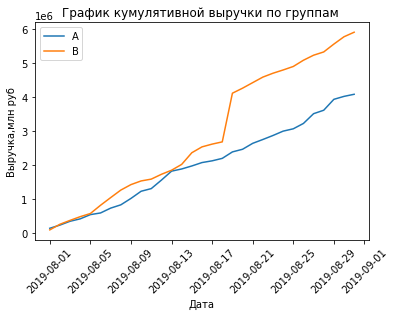

In [24]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=45) 
plt.xlabel('Дата')
plt.ylabel('Выручка,млн руб')
plt.title('График кумулятивной выручки по группам ')
plt.legend() 
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. Хороший знак.
Однако график выручки группы B в одной точке (18/08/2019) резко вырастает. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

#### График кумулятивного среднего чека по группам

Построим график кумулятивного среднего чека по группам

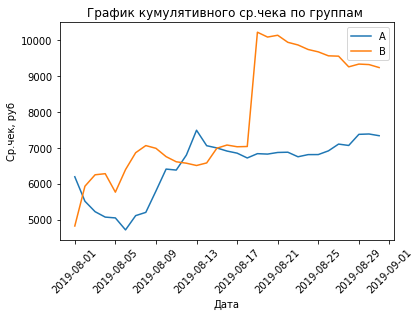

In [25]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45) 
plt.xlabel('Дата')
plt.ylabel('Ср.чек, руб')
plt.title('График кумулятивного ср.чека по группам ')
plt.legend() 
plt.show()

Видим, что средний чек по обоим группам не равномерен. Только после середины месяца ср.чек в группе А выравнивается. В группе B в в середине месяца видимо попали крупные заказы (резкий всплеск на графике). Поэтому ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

#### График относительного изменения кумулятивного среднего чека группы B к группе A. 

Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

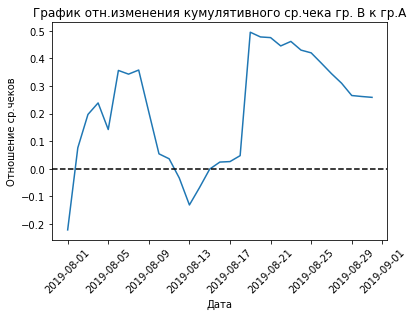

In [26]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
)

# cтроим отношение средних чеков
plt.plot(
    mergedCumulativeRevenue['date'], 
    (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']
    )/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.xticks(rotation=45) 
plt.xlabel('Дата')
plt.ylabel('Отношение ср.чеков')
plt.title('График отн.изменения кумулятивного ср.чека гр. B к гр.A')
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Где-то уж точно спрятались крупные заказы и выбросы

#### График кумулятивного среднего количества заказов на посетителя по группам

Построим график кумулятивного среднего количества заказов на посетителя по группам

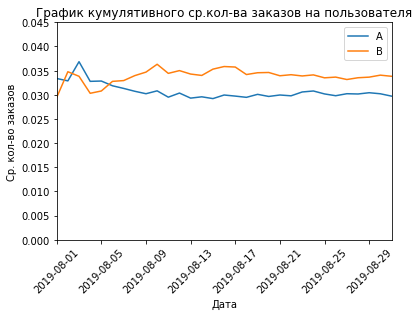

In [27]:
# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis(["2019-08-01", "2019-08-31", 0, 0.045])

plt.xticks(rotation=45) 
plt.xlabel('Дата')
plt.ylabel('Ср. кол-во заказов')
plt.title('График кумулятивного ср.кол-ва заказов на пользователя')
plt.show()

Группы колебались около одного значения, но затем у группы В среднее количество заказов вырвалось вперёд и зафиксировалось, а у группы A — просело, но тоже зафиксировалось.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

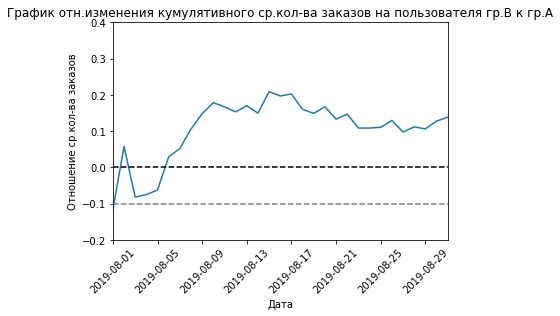

In [28]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
)

plt.plot(
    mergedCumulativeConversions['date'], 
    mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1
)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.2, 0.4])

plt.xticks(rotation=45) 
plt.xlabel('Дата')
plt.ylabel('Отношение ср.кол-ва заказов')
plt.title('График отн.изменения кумулятивного ср.кол-ва заказов на пользователя гр.В к гр.А')
plt.show()

В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. Потом среднее количество заказов на посетителя для группы B снова уменьшалось, но теперь постепенно растёт
В целом отношение среднего количества заказов на посетителя ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Стоит проанализировать аномалии, возможно, они изменят картину.

### Точечные графики метрик и определение аномалий

#### Точечный график количества заказов по пользователям

Построим точечный график количества заказов по пользователям

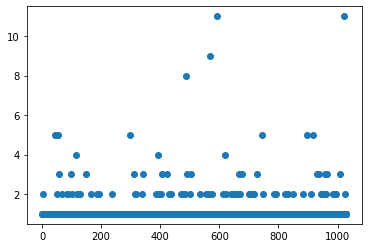

In [29]:
#посчитаем кол-во заказов каждого пользователя
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
#переименуем колонки
ordersByUsers.columns = ['visitor_id', 'orders']

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])

Видим, что большинство пользователей с 1-2 заказами. Проверим дальше, аномалия ли это.

#### 95-й и 99-й перцентили количества заказов на пользователя

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [30]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей оформляли больше чем 2 заказа, не более 1% - более чем 2 заказа.  
Разумно выбрать 3 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

#### Точечный график стоимостей заказов

Построим точечный график стоимостей заказов

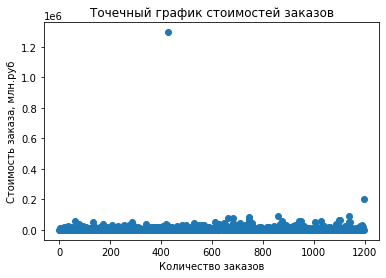

In [31]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
 
plt.xlabel('Количество заказов')
plt.ylabel('Стоимость заказа, млн.руб')
plt.title('Точечный график стоимостей заказов')
plt.show()

Видим очень дорогой заказ, выше 1,2 млн.руб. Посмотрим поближе на данные без этого заказа.

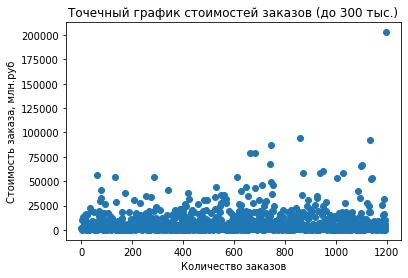

In [32]:
# Фильтрация заказов стоимостью до 300 тыс.
filtered_orders = orders[orders['revenue'] < 300000]

x_values = pd.Series(range(0, len(filtered_orders)))
plt.scatter(x_values, filtered_orders['revenue'])

plt.xlabel('Количество заказов')
plt.ylabel('Стоимость заказа, млн.руб')
plt.title('Точечный график стоимостей заказов (до 300 тыс.)')
plt.show()


Видим, что чаще всего заказы имеют стоимость до 30 тыс. Проверим аномалии.

#### 95-й и 99-й перцентили стоимости заказов

Посчитаем 95-й и 99-й перцентили стоимости заказов

In [33]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% заказов дороже 28 000 рублей.
Поэтому будем считать верхней границей стоимости заказа 28 тыс руб 

### Статистическая значимость различий метрик по "сырым" и "очищенным" данным

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

In [34]:
#количество пользователей в выбранную дату в группе A
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

#количество пользователей до выбранной даты включительно в группе A
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

#количество пользователей в выбранную дату в группе B
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

#количество пользователей до выбранной даты включительно в группе B
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

#количество заказов и выручка в выбранную дату в группе A
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

#суммарное число заказов и суммарная выручка до выбранной даты включительно в группе A
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

#количество заказов и выручка в выбранную дату в группе B
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

#суммарное число заказов и суммарная выручка до выбранной даты включительно в группе B
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

#соберем все в одной переменной
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

#проверим
data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [35]:
#создадим переменные по группам для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

In [36]:
#создадим переменные, в которых пользователям из разных групп будет соответствовать количество заказов
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# p-value
print("{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

#относительный прирост среднего числа заказов группы B
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.017
0.138


P-value значительно меньше 0.05. Значит, нулевую гипотезу можно опровергнуть и считать, что в ср. кол-ве заказов между группами есть различия. Среднее кол-во заказов группы B выше среднего чека группы A на 13,8%.

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

In [37]:
# p-value
print('{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

#относительный прирост среднего чека группы B
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. При этом по "сырым" данным средний чек группы B выше среднего чека группы A на 25,9%.

#### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Принимаем за аномальных пользователей с заказами более 3 и стоимостью более 28 тыс.

In [38]:
#отберем пользователей с заказами более 3
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['visitor_id'],
    ],
    axis=0,
)
#и стоимостью заказа выше 28 тыс
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']
#соединим данные
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
#посмотрим сколько их
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
Name: visitor_id, dtype: int64
63


Аномальных пользователей всего 63.

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [39]:
#очистим данные от аномалии
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# p-value
print('{0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

#относительный прирост среднего числа заказов группы B
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.018
0.148


Результаты по среднему количеству заказов практически не изменились. Между группами есть разница по ср.кол-ву заказов, в группе B их на 14,8% больше.

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [40]:
# p-value
print(
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

#относительный прирост среднего чека группы B
print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.977
-0.017


P-value увеличился, значит различий по ср.чеку между группами нет. Ср.чек группы В на 1,7% ниже ср.чека гр.А

### Решение по результатам теста

Имеющиеся факты:
- Есть статистически значимое различие по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A 
- График различия среднего чека говорит о том, что результаты группы B лучше результатов группы А в связи с выбросом и постепенно ухудшаются.

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. При имеющихся данных сегмент B стабильно лучше сегмента A по среднему количеству заказов при сохранении среднего чека.

## ОБЩИЙ ВЫВОД

**Краткий обзор проведённой работы:**

В нашем распоряжении 1197 строк данных о заказах, 62 строки данных о количестве пользователей по группам за период с 1 по 31 августа 2019 и 9 гипотез. 

Проведена предобработка:
1. изменены типы данных:
 - date — дата
2. скорректированы наименования столбцов 
 - hypothesis — краткое описание гипотезы
 - reach — охват пользователей по 10-балльной шкале
 - impact — влияние на пользователей по 10-балльной шкале
 - confidence — уверенность в гипотезе по 10-балльной шкале
 - efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале
 - transaction_id — идентификатор заказа
 - visitor_id — идентификатор пользователя, совершившего заказ
 
    
**Главные выводы** 

Самыми приоритетными гипотезами (из 9 предложенных) являются:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
- Запустить акцию, дающую скидку на товар в день рождения

А/В тест:
- Есть статистически значимое различие по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A 
- График различия среднего чека говорит о том, что результаты группы B лучше результатов группы А в связи с выбросом и постепенно ухудшаются.

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным.   
При имеющихся данных сегмент B стабильно лучше сегмента A по среднему количеству заказов при сохранении среднего чека.
